In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('../light_mode.mplstyle')

import sys
sys.path.append('../src/')

from sim import Init, Grid
import constants
from helper import *

In [2]:
########################################################
#                 Simulation Parameters                #
########################################################

Nside     = 256               #number of cells per side
nH_init   = 1e2               #cm^-2
vx_init   = 0                 #cm/s
vy_init   = 0                 #cm/s
temp_init = 100               #K
boxsize   = 10*constants.pc   #cm
Ndot      = 2e48              #photons/s
c_red     = 6e-4*constants.c  #cm/s
time_sim  = 100*constants.kyr #s   
x_init    = 0.001

rho_init  = nH_init*constants.mH
p_init    = nH_init*constants.kB*temp_init

In [3]:
########################################################
#                 Define Units of Box                  #
########################################################

unit = SimpleNamespace(
    length = boxsize,
    time   = constants.kyr,
    mass   = constants.Msol,
    phot   = 1e48
)
unit.density = unit.mass/unit.length**2
unit.vel = unit.length/unit.time
unit.energy_density = unit.density*unit.vel**2

In [29]:
########################################################
#                  Initialize & Run                    #
########################################################

grid = Grid(N=Nside, C=0.4, bc_typ=[NEU, NEU], rsolve=HLL, sloper=MONCEN, c_red=c_red)

with Init(grid) as grid:
    
    grid.w[RHO] = rho_init/unit.density
    grid.w[VX]  = vx_init/unit.vel
    grid.w[VY]  = vy_init/unit.vel
    grid.w[P]   = p_init/unit.energy_density
    grid.w[ION] = x_init*rho_init/unit.density
    grid.urad[NPHOT] = 1e-3

Nsteps = 100
Nskips = 1
Nframes = Nsteps//Nskips

frames = []
for i in range(Nsteps):
    
    grid.inject([0.5, 0.5], Ndot/(unit.phot/unit.time)/(grid.dx)**2)
    ### fluid + radiation + thermochemistry
    grid.step(unit)

    if i % Nskips == 0:
        frames.append(grid.u[ION]/grid.u[RHO])

        

Ion Fraction Failed: Halving time step and starting over
Ion Fraction Failed: Halving time step and starting over
Ion Fraction Failed: Halving time step and starting over
Ion Fraction Failed: Halving time step and starting over


/opt/homebrew/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


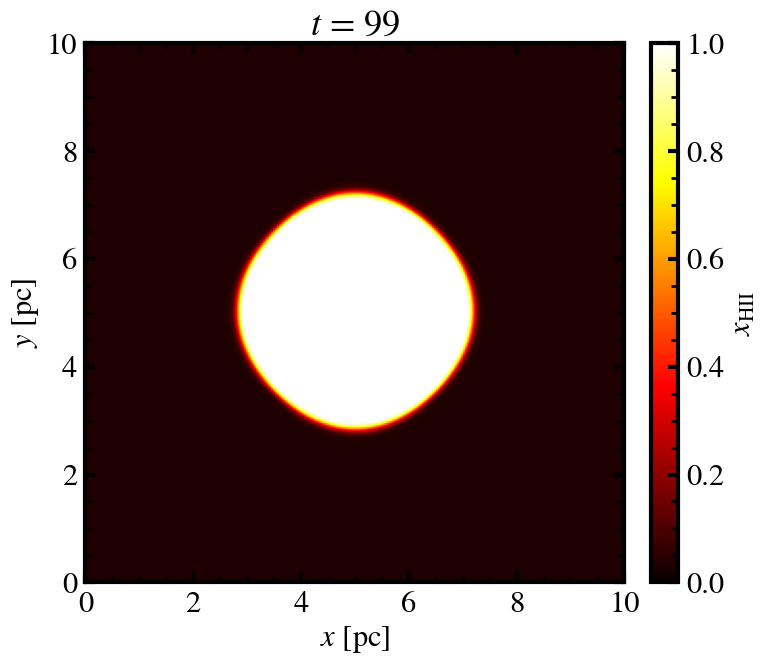

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

cv0 = frames[0]
im = ax.imshow(cv0, origin='lower', 
               extent=[0, 10, 0, 10],
               cmap='hot') 
cb = fig.colorbar(im, cax=cax)
tx = ax.set_title('$t$ = 0')
ax.set_xlabel(r'$x$ [${\rm pc}$]')
ax.set_ylabel(r'$y$ [${\rm pc}$]')
cb.set_label(r'$x_{\rm HII}$')

def animate(i):
    arr = frames[i]
    vmax     = 1
    vmin     = 0
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text('$t$ = {0}'.format(i))


ani = animation.FuncAnimation(fig, animate, frames=Nframes)
# ani.save("../media/ionization_movie.mp4", fps=30, dpi=300)

plt.show()